# Fake News Detection using NLP and Machine Learning

This notebook demonstrates an end-to-end fake news classification pipeline. It includes text preprocessing, feature extraction, model training, evaluation, and result interpretation.

The steps we take are:

- Non-alphabet filtering
- Punctuation removal
- Lowercasing
- Basic tokenization
- Stopword removal
- Stemming
- Rejoining and vectorizing
- Model Design and Evaluation

## 1. Imports and Setup

- numpy
➡️ Used for numerical operations (arrays, math functions, etc.)

- pandas
➡️ Used for loading, analyzing, and manipulating tabular data (DataFrames)

- re
➡️ Used for regular expressions — e.g., removing non-alphabet characters during text cleaning

- nltk
➡️ Natural Language Toolkit — provides tools like stopwords, tokenizers, and stemmers for text preprocessing

- os
➡️ Used for file and directory handling

- seaborn
➡️ Statistical data visualization library, used for heatmaps, countplots, etc.

- matplotlib.pyplot
➡️ Used for plotting graphs (bar charts, confusion matrix, etc.)

- WordCloud
➡️ Used to generate word clouds that visualize the most frequent words in the dataset

- stopwords
➡️ Access to common English stopwords like "the", "is", "and", etc. (to be removed during preprocessing)

- PorterStemmer
➡️ Stemming tool to reduce words to their root form (e.g., “running” → “run”)

- TfidfVectorizer
➡️ Converts text into numerical features using TF-IDF (Term Frequency–Inverse Document Frequency)

- LogisticRegression
➡️ A simple linear classifier used for binary classification (e.g., real vs fake news)

- MultinomialNB
➡️ Probabilistic classifier especially suited for text data with discrete features (like word counts or TF-IDF)

- XGBClassifier
➡️ Gradient boosting classifier, good at handling complex patterns and typically gives strong performance

- SVC
➡️ Support Vector Classifier — works well on high-dimensional feature spaces like TF-IDF vectors


In [4]:

import numpy as np
import pandas as pd
import re
import nltk
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load and Explore the Dataset

In [5]:

data_path = 'fake_train.csv'  # adjust path if running locally
news = pd.read_csv(data_path)
print("Dataset shape:", news.shape)
news.head()


Dataset shape: (20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## 3. Data Cleaning and Preprocessing

#### First we will replace all null values with empty strings.

In [6]:

print("Missing values:", news.isnull().sum())
news = news.fillna('')


Missing values: id           0
title      558
author    1957
text        39
label        0
dtype: int64


##### For quicker processing we will ignore the news text and use the authors and headlines in our model for now.

In [7]:

news['content'] = news['author'] + ' ' + news['title']


### 📈 Exploratory Data Analysis

##### Let's check for class imbalance.

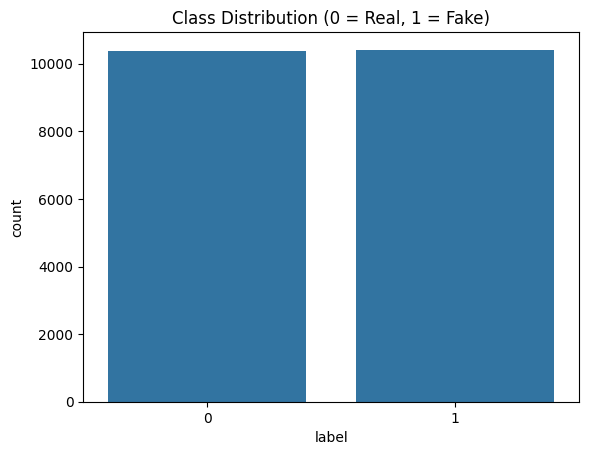

In [8]:

# Class distribution
sns.countplot(x='label', data=news)
plt.title("Class Distribution (0 = Real, 1 = Fake)")
plt.show()


Classes are pretty well-balanced, so no need for SMOTE.

Let's generate word clouds that visualize the most frequent words in the dataset.

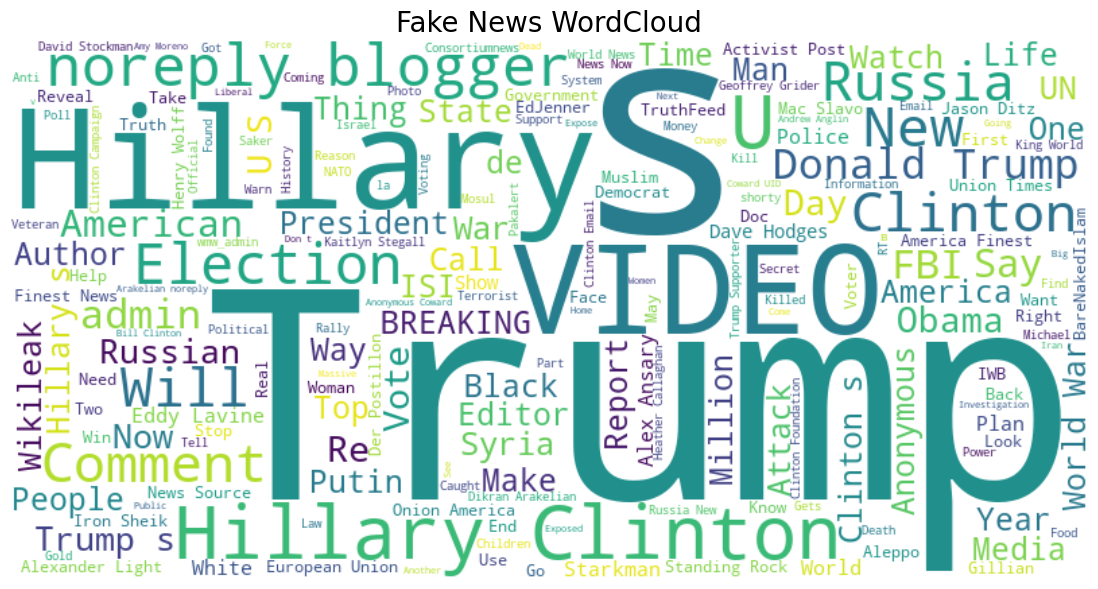

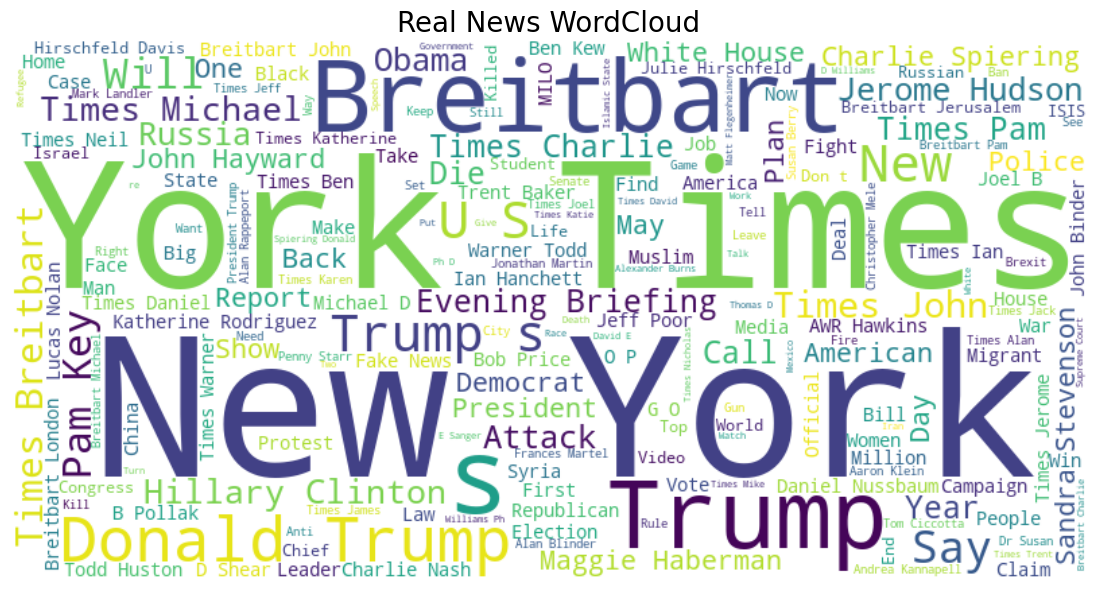

In [9]:

# WordCloud for Fake and Real News
def show_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(data))
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

fake_text = news[news['label'] == 1]['content']
real_text = news[news['label'] == 0]['content']

show_wordcloud(fake_text, "Fake News WordCloud")
show_wordcloud(real_text, "Real News WordCloud")


### 🧠 Text Cleaning and Stemming

##### The following function processes the text in the following steps:

- Removes all characters except letters (i.e., removes numbers, punctuation, symbols)
- Converts all text to lowercase
- Splits the text into individual words (basic tokenization)
- Removes stopwords (like "the", "is", "and", etc.)
- Applies stemming to reduce words to their root form (e.g., "running" → "run")
- Joins the cleaned words back into a single string

In [10]:

stemmer = PorterStemmer()

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    return " ".join(text)

news['content'] = news['content'].apply(preprocess_text)


## 4. Feature Extraction

The following code prepares the features and labels for model training. It assigns the cleaned news text to X and the labels (real or fake) to y. Then, it uses TfidfVectorizer to convert the text into numerical features based on word importance, keeping only the top 5000 most frequent unique words.

Finally, the data is converted into a dense array of shape (number of examples, 5000) so it can be used by machine learning models. Each row is a training example (a news) and each column records the frequency of one word in that news.

In [11]:

X = news['content']
y = news['label']

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X).toarray()


## 5. Model Training and Evaluation

In [ ]:
# Splitting into train and test set for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)


### 🧠 Models Used for Fake News Classification

**1. Logistic Regression**  
A simple yet powerful linear classifier that works well for binary classification tasks like fake vs. real news. It performs well with TF-IDF features and is easy to interpret.

**2. Naive Bayes (MultinomialNB)**  
A probabilistic model that's particularly effective for text classification problems. It assumes feature independence (the 'Naive' assumption that works surprisingly well) and works well with TF-IDF or word count vectors, making it fast and suitable for high-dimensional text data.

**3. XGBoost (Extreme Gradient Boosting)**  
An advanced boosting algorithm that builds multiple decision trees sequentially and optimizes performance. It handles complex patterns in data, performs well in competitions, and is known for its high accuracy on structured and text data alike.

**4. Support Vector Machine (SVM)**  
A powerful classifier that finds the best boundary between classes in high-dimensional spaces. Using a linear kernel works well with TF-IDF features, and SVM is especially effective when there’s a clear margin of separation.

In [13]:

models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(kernel='linear')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.9805
Naive Bayes Accuracy: 0.9558


c:\PYTHON\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:48:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9894
SVM Accuracy: 0.9916


The SVM model performed the best, but we will still recheck its performace with other evaluation metrics.

### 📊 Evaluation Metrics

Let's see the model's performance against Type I and Type II errors by seeing the precision, recall and F-1 scores.

In [14]:

# Use best model (Support Vector Machine)
final_model = SVC(kernel='linear')
final_model.fit(X_train, y_train)
preds = final_model.predict(X_test)

print("Confusion Matrix:", confusion_matrix(y_test, preds))
print("Classification Report:", classification_report(y_test, preds))


Confusion Matrix: [[2058   19]
 [  16 2067]]
Classification Report:               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2077
           1       0.99      0.99      0.99      2083

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



Very promising!

### 🔥 Visualizing Confusion Matrix

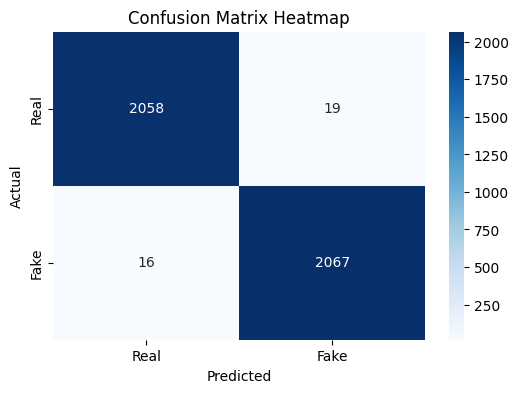

In [15]:

import seaborn as sns

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


Our model misclassified only 16 fake news samples as real and only 19 real news samples as fake, out of 4160 total test samples. That is satisfactory performance. We would not achieve a better result even if using entire news text instead of author and headline (already checked).

### 📊 Model Comparison Bar Chart

c:\PYTHON\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:57:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


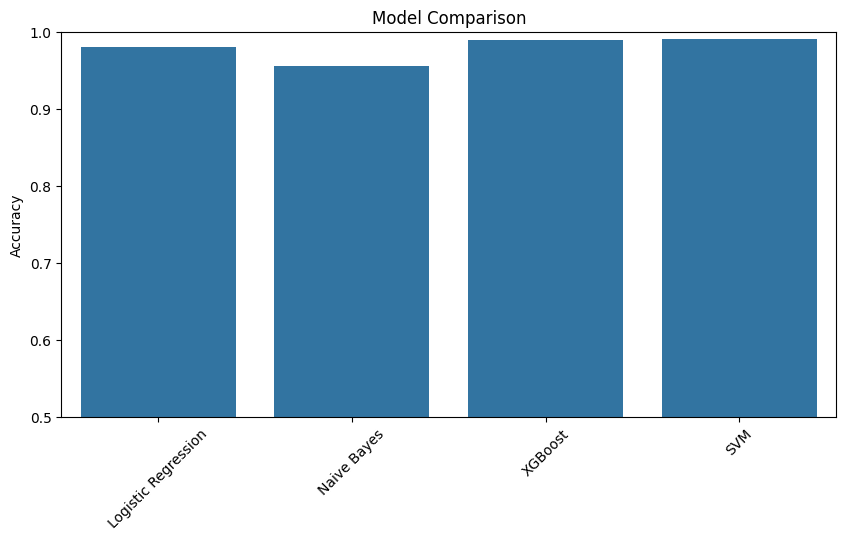

In [16]:

model_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_scores[name] = acc

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()))
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0.5, 1)
plt.xticks(rotation=45)
plt.show()


### 🧠 Top Features by TF-IDF Score (SVM)

In [17]:

feature_names = vectorizer.get_feature_names_out()
coefs = final_model.coef_[0]
top_positive = np.argsort(coefs)[-20:]
top_negative = np.argsort(coefs)[:20]

print("Top words indicating FAKE news:")
for i in top_positive[::-1]:
    print(f"{feature_names[i]}: {coefs[i]:.4f}")

print("\nTop words indicating REAL news:")
for i in top_negative:
    print(f"{feature_names[i]}: {coefs[i]:.4f}")


Top words indicating FAKE news:
hardest: 1.6901
kesel: 1.5233
comment: 1.4967
edjenn: 1.4231
com: 1.3847
barenakedislam: 1.3308
mitchel: 1.2460
gold: 1.1199
hillari: 1.1135
admin: 1.0556
centuri: 1.0535
marqui: 1.0029
wolff: 0.9830
union: 0.9783
stevew: 0.9652
unruh: 0.9577
doc: 0.9427
falkenberg: 0.9254
daili: 0.9008
imperi: 0.8994

Top words indicating REAL news:
york: -13.2694
breitbart: -11.2434
hayward: -5.3868
nussbaum: -5.3475
ph: -4.5691
time: -4.3327
montgomeri: -4.2484
riehl: -4.2375
binder: -3.8645
tomlinson: -3.8164
martel: -3.7019
rodriguez: -3.6684
hale: -3.5911
hudson: -3.5117
charli: -3.3527
kew: -3.3379
jerom: -3.2889
klein: -3.1242
pollak: -3.1210
deacon: -3.0941


## ✅ 6. Conclusion

- SVM performed the best, followed by XGBoost and Logistic Regression.
- TF-IDF and simple NLP preprocessing are effective for fake news detection.
- Could be further improved with deep learning (e.g., LSTM or BERT).
